# **Developing a Facemask Detector**

#### Link to Dataset: https://bit.ly/gw_coders_workshop


## Connect Colab to Storage(Google Drive)

In [9]:
from google.colab import drive
import sys

# Mount Google Drive
drive.mount('/content/drive')

# Get the absolute path of the current folder
BASE_DIR = '/content/drive/My Drive/gw_coders_workshop/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import relevant libraries

In [10]:
# Library Imports
# %%--------------------------------------Imports
import os
import copy
import random
from sklearn.metrics import accuracy_score
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision import models
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from PIL import Image

### Set seed for random 

In [11]:
# %% --------------------
seed = 42

# %% --------------------
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True

### Define paths and constants

In [12]:
# %% --------------------
# BASE_DIR = "/home/ubuntu/Deep-Learning/Exam2/"
save_path = BASE_DIR + "saved_models/"
os.makedirs(save_path, exist_ok=True)

# %% --------------------Configurable Parameters
model_name = "resnet50"

# covered, uncovered, incorrect
num_of_classes = 3

EPOCHS = 10
LR = 0.001

BATCH_SIZE = 512

# feature_extract_param = True means all layers frozen except the last user added layers
# feature_extract_param = False means all layers unfrozen and entire network learns new weights
# and biases
feature_extract_param = True

## Define relevant functions

In [13]:
# %% --------------------
def set_parameter_requires_grad(model, feature_extracting):
    # feature_extract_param = True means all layers frozen except the last user added layers
    # feature_extract_param = False means all layers unfrozen and entire network learns new weights
    # and biases
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [14]:
# %% --------------------initialize pretrained model & return input size desired by pretrained model
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet18":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "resnet50":
        """ Resnet50
        """
        model_ft = models.resnet50(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Sequential(nn.Dropout(0.3), nn.Linear(num_ftrs, num_classes))
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

In [15]:
# %% -------------------- plot train loss vs valid loss during training ----------------------------------------------
def plot_error(train_loss, valid_loss):
    plt.plot([x for x in range(len(train_loss))], train_loss, label='train', color='r')
    plt.plot([x for x in range(len(train_loss))], valid_loss, label='validation', color='g')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train vs Validation Loss')
    plt.legend()
    plt.show()

## Build Model architecture

In [16]:
# %% --------------------
# Initialize the model for this run
model, input_size = initialize_model(model_name, num_of_classes, feature_extract_param,
                                     use_pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


## Load data and define transforms

In [17]:
# %%--------------------------Load Data
# train transformation
# some augmentation
train_transformer = transforms.Compose([
    transforms.Resize(input_size),
    transforms.ToTensor(),
    transforms.ColorJitter(saturation=[0, 1]),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

# validation and holdout transformation is generic
# normalization and resize
generic_transformer = transforms.Compose([
    transforms.Resize(input_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

# create dataset using ImageFolder
train_dataset = datasets.ImageFolder(BASE_DIR + "root_data/train/", transform=train_transformer)

val_dataset = datasets.ImageFolder(BASE_DIR + "root_data/validation/",
                                   transform=generic_transformer)

# create dataloader
train_dataloader = DataLoader(train_dataset, num_workers=2, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, num_workers=2, batch_size=BATCH_SIZE, shuffle=True)
# holdout_dataloader = DataLoader(holdout_dataset, num_workers=2, batch_size=BATCH_SIZE, shuffle=True)

# create dataloader dictionary
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

## Print model summary

In [18]:

# %% --------------------
# Print the model we just instantiated
print(model)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Define optimizers and hyperparameters

In [19]:
# %% --------------------
# get all parameters from model
params_to_update = model.parameters()

# if feature_extract_param is True, then we freeze all layers except the user added layers
if feature_extract_param:
    params_to_update = []
    for name, param in model.named_parameters():
        if param.requires_grad:
            params_to_update.append(param)

# %% --------------------
optimizer_ft = optim.Adam(params_to_update, lr=LR)


# %% --------------------
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# %% --------------------Criterion of CrossEntropy since we are doing classification
# CrossEntropyLoss combines nn.LogSoftmax() and nn.NLLLoss() in one single class.
# https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
criterion = nn.CrossEntropyLoss()


# Train Model

In [20]:
# %% --------------------
def train_model(model, dataloaders, criterion, optimizer, num_epochs, is_inception=False):
    val_acc_history = []
    train_loss = []
    valid_loss = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # FORWARD
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output.
                    # In train mode we calculate the loss by summing the final output and the
                    # auxiliary output but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4 * loss2
                    else:
                        # make prediction
                        outputs = model(inputs)
                        # find loss
                        loss = criterion(outputs, labels)

                    # select the class with highest value
                    # 1 specifies the axis
                    _, preds = torch.max(outputs, 1)

                    # BACKWARD + OPTIMIZE only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)

                # finding accuracy
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # store train and valid loss separately
            if phase == 'train':
                train_loss.append(epoch_loss)
            else:
                valid_loss.append(epoch_loss)

            # plot train and valid loss after after 3 epochs
            if phase == "val":
                plot_error(train_loss, valid_loss)

            # deep copy the best model
            # model checkpoint
            if phase == 'val' and epoch_acc > best_acc:
                # save model state based on best val accuracy per epoch
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, val_acc_history, optimizer

Epoch 0/9
----------
train Loss: 1.1384 Acc: 0.3204
val Loss: 1.1541 Acc: 0.3737


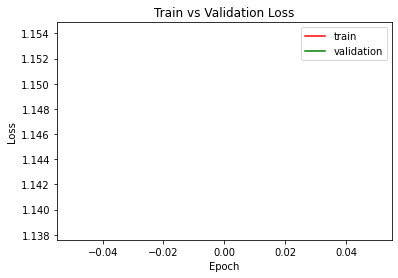


Epoch 1/9
----------
train Loss: 1.1144 Acc: 0.3922
val Loss: 1.0293 Acc: 0.5455


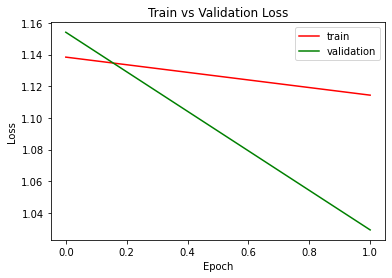


Epoch 2/9
----------
train Loss: 1.0262 Acc: 0.4790
val Loss: 0.9883 Acc: 0.3838


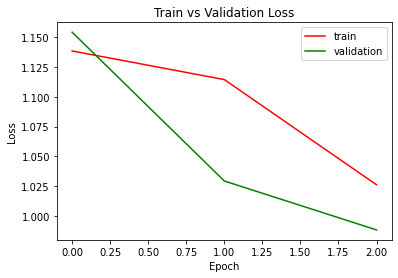


Epoch 3/9
----------
train Loss: 0.9773 Acc: 0.4581
val Loss: 0.9197 Acc: 0.6162


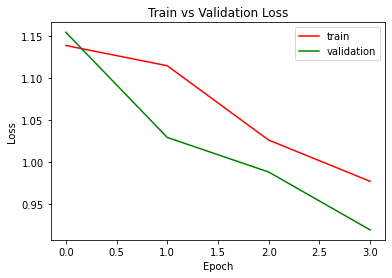


Epoch 4/9
----------
train Loss: 0.9221 Acc: 0.5719
val Loss: 0.8629 Acc: 0.7778


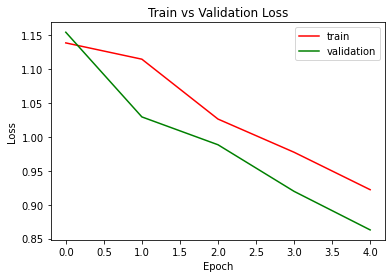


Epoch 5/9
----------
train Loss: 0.8442 Acc: 0.7335
val Loss: 0.8250 Acc: 0.7374


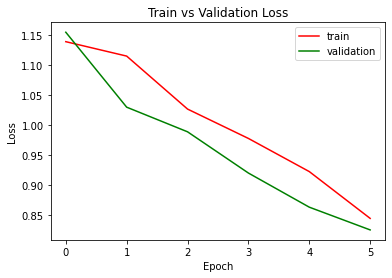


Epoch 6/9
----------
train Loss: 0.8303 Acc: 0.7335
val Loss: 0.7860 Acc: 0.7879


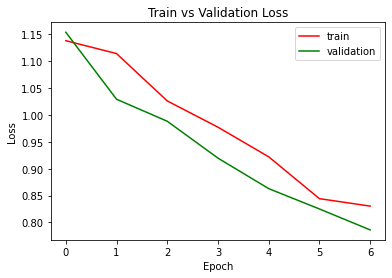


Epoch 7/9
----------
train Loss: 0.7605 Acc: 0.7874
val Loss: 0.7471 Acc: 0.8586


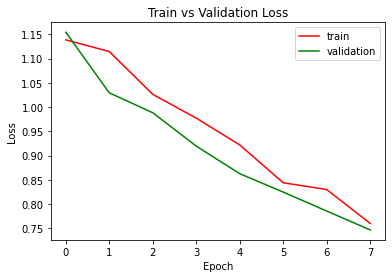


Epoch 8/9
----------
train Loss: 0.7288 Acc: 0.8234
val Loss: 0.7172 Acc: 0.8687


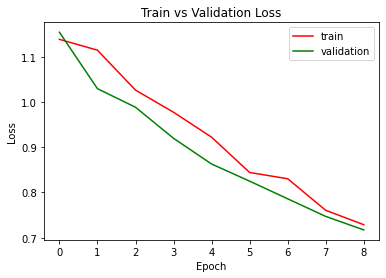


Epoch 9/9
----------
train Loss: 0.6986 Acc: 0.8503
val Loss: 0.6935 Acc: 0.8788


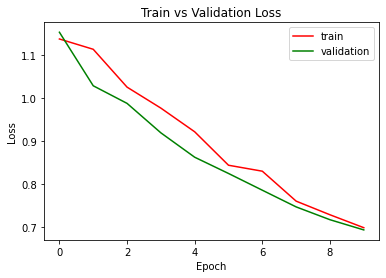


Best val Acc: 0.878788


In [21]:
# %% --------------------
model.to(device)
# store class labels
idx_to_class = { v : k for k,v in train_dataset.class_to_idx.items()}
# %%--------------------------
model_resnet50, hist, optimizer_resnet50 = train_model(model, dataloaders_dict, criterion, optimizer_ft,
                                                       num_epochs=EPOCHS, is_inception=(model_name == "inception"))

# %% --------------------
torch.cuda.empty_cache()

checkpoint = {'base_model': model,
              'optim_state_dict': optimizer_resnet50.state_dict(),
              'state_dict': model_resnet50.state_dict(),
              'class_to_idx': idx_to_class
             }

torch.save(checkpoint, 'resnet50_2.pt')

## Evaluate Model

In [22]:
# %% --------------------Evaluation metrics
def find_evaluation_metrics(folder):
    model.eval()

    # use generic transformer
    acc_dataset = datasets.ImageFolder(BASE_DIR + "root_data/" + folder + "/",
                                       transform=generic_transformer)
    acc_dataloader = DataLoader(acc_dataset, num_workers=2, batch_size=BATCH_SIZE, shuffle=True)

    pred = []
    actual = []

    # get all outputs
    for inputs, label in acc_dataloader:
        with torch.no_grad():
            # logit
            predictions = model(inputs.to(device))

            # find index with max logit
            val, index = torch.max(predictions, 1)

            # append prediction
            pred.extend(index.tolist())

            # append actual
            actual.extend(label.tolist())

    accuracy = accuracy_score(actual, pred)
    f1 = f1_score(actual, pred, average='micro')
    cm = confusion_matrix(actual, pred)
    print("Accuracy::" + str(accuracy))
    print("F1 Score::" + str(f1))
    print("Confusion Matrix::" + str(cm))

In [23]:
# %% --------------------
print("Train Evaluation Metrics")
print("-" * 10)
find_evaluation_metrics("train")
print()
torch.cuda.empty_cache()


Train Evaluation Metrics
----------
Accuracy::0.9281437125748503
F1 Score::0.9281437125748502
Confusion Matrix::[[104   6   0]
 [  8 104   2]
 [  1   7 102]]



In [24]:
# %% --------------------
print("Validation Evaluation Metrics")
print("-" * 10)
find_evaluation_metrics("validation")
print()
torch.cuda.empty_cache()



Validation Evaluation Metrics
----------
Accuracy::0.8787878787878788
F1 Score::0.8787878787878788
Confusion Matrix::[[29  4  0]
 [ 3 29  1]
 [ 0  4 29]]



#Inference

In [25]:
# define transforms
process_transform = transforms.Compose([transforms.Resize(256),
                                        transforms.CenterCrop(224),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406],
                                                             [0.229, 0.224, 0.225])
                                        ])


def process_image(image, asNumpy=False):
	"""
	Function to read image and perform transforms
	:param image: image path(str)
	:param asNumpy: specification if numpy image be return (bool)
	:return: transformed images (tensor)
	"""

	im = Image.open(image)
	im = im.convert("RGB")
	im = process_transform(im)
	return im if not asNumpy else im.numpy()

In [26]:
def show_image(image, ax=None, title=None):
	"""
	Function to show an image that is a tensor
	:param image: image path (str)
	:param ax: axis plot
	:param title: title of plot
	:return:
	"""
	if ax is None:
		fig, ax = plt.subplots()

	# PyTorch tensors assume the color channel is the first dimension
	# but matplotlib assumes is the third dimension
	image = image.transpose(1, 2, 0)

	# Undo preprocessing transforms on tensor image
	mean = np.array([0.485, 0.456, 0.406])
	std = np.array([0.229, 0.224, 0.225])
	image = std * image + mean

	# Image needs to be clipped between 0 and 1 or it looks like noise when displayed
	image = np.clip(image, 0, 1)

	ax.imshow(image)
	plt.show()

In [27]:
def detect_mask(image_path, model, k=3):
	"""
	 Function to predict the class of an image using the trained model
	:param image_path: directory to where image is stored (str)
	:param model: trained model
	:param k: top class from the model prediction
	:return: k top probabilities and class from model output
	"""

	model.to(device)
	model.eval()
	image = process_image(image_path).unsqueeze_(0)
	output = model(image.to(device))
	output = torch.nn.functional.softmax(output, 1)
	output = output.float().cpu()
	return torch.topk(output, k)

In [28]:
def plot_probs(face_class, face_probs):

	plt.rcdefaults()
	fig, ax = plt.subplots()

	y_pos = np.arange(len(face_class))

	ax.barh(y_pos, face_probs, color='blue', ecolor='black')
	ax.set_yticks(y_pos)
	ax.set_yticklabels(face_class)
	ax.invert_yaxis()
	plt.show()

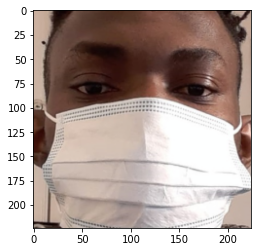

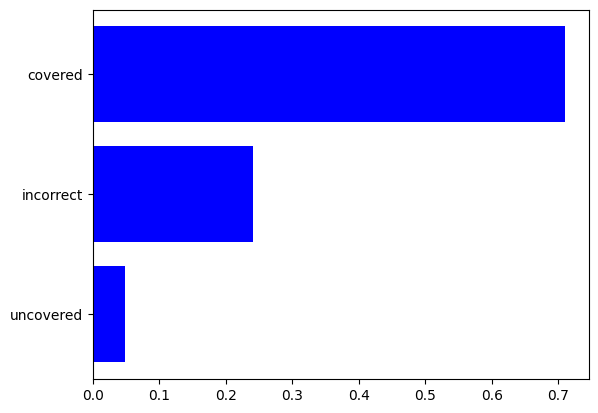

In [29]:
image_1 = BASE_DIR + "test/test16.jpg"
face_image = process_image(image_1, asNumpy=True)
# face_image.shape
show_image(face_image)

# load model from disk
t_model = torch.load("resnet50_2.pt")
facemask_model = t_model['base_model']
idx_to_class = t_model['class_to_idx']
facemask_model.load_state_dict(t_model['state_dict'])


# get top probabilities and classes
top_probs, top_classes = detect_mask(image_1, facemask_model)

face_class = [idx_to_class[x.item()] for x in top_classes[0]]
face_probs = [x.item() for x in top_probs[0]]

plot_probs(face_class, face_probs)